# 🫁 Multimodal Survival Modeling in Pulmonary Tuberculosis
#### Chest X-ray + Clinical Covariates via Cross-Modal Attention

**Author:** Dr. Ikechukwu Ephraim Ugbo, MD
**Project:** Innovative AI Healthcare Solutions
**Framework:** TensorFlow / Keras

#### ---
#### 🔬 Study Context & SOTA References
##### This notebook implements a state-of-the-art (SOTA) multimodal architecture for predicting **time-to-major-complication** in TB patients.

##### Moving beyond simple feature concatenation, we implement **Cross-Modal Attention** to allow clinical covariates (e.g., HIV status, Age) to dynamically "attend" to specific regions of the chest X-ray. This approach is supported by recent literature:

##### **Architecture:** We utilize a transformer-based fusion strategy, which has shown superior performance in handling heterogeneous medical data compared to unimodal baselines.
##### **Modality Interaction:** Modeling the complex non-linear interactions between imaging and clinical variables (e.g., "how does diabetes status alter the risk implication of a cavitary lesion?") is critical for robust prognosis.
##### **Backbone:** We use a DenseNet121 backbone for visual feature extraction, a proven strategy for medical imaging tasks.
#
#### ---

In [2]:
# ==========================================
# Imports & Setup
# ==========================================
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


# Import custom modules

# 1. Get current directory
current_dir = os.getcwd()

# 2. Check if we are in 'notebooks' and move up if needed
if current_dir.endswith("notebooks"):
    # Move up one level to project root
    os.chdir("..")
    print(f"Changed working directory to: {os.getcwd()}")
    
    # Add root to python path so we can import src
    sys.path.append(os.getcwd())
else:
    print(f"Current working directory: {os.getcwd()}")

# Ensure your src/ folder is accessible in the python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.config import *
from src.data_utils import (
    generate_synthetic_tb_clinical_data, 
    load_tb_cxr_dataset, 
    train_val_split,
    # Assuming you added this function based on our previous step:
    # create_matched_dataframe 
)
from src.model_utils import TBSurvivalNet
from src.survival_utils import harrell_c_index
from src.training_utils import compile_survival_model
from src.explainability_utils import generate_gradcam

# Set seeds for reproducibility
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPUs Available: {tf.config.list_physical_devices('GPU')}")

c:\Users\ugboi\Desktop\ai_innovative_solutions\tb-cxr-survival\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Changed working directory to: c:\Users\ugboi\Desktop\ai_innovative_solutions\tb-cxr-survival
TensorFlow Version: 2.20.0
GPUs Available: []


#### 1. Data Preparation & Synchronization

**Challenge:** A common issue in multimodal medical AI is data heterogeneity and missing modalities.

**Strategy:**
1. We load the raw **Shenzhen TB Chest X-ray** dataset.
2. We generate synchronized synthetic clinical data (HIV,bmi etc.), (Age & Sex are taken from the shenzhen_metadata.csv) that matches the *exact* number of images, data leakage is ignored here as we do not have the patient id given here.
3. We create a "Master Key" dataframe to ensure Image $i$ always corresponds to Clinical Vector $i$.

In [7]:
# ==========================================
# Data Loading (Hybrid: Real Images + Real Metadata + Smart Synthetic Outcomes)
# ==========================================

# 1. Define Paths
IMAGE_DATA_DIR = "data/raw/images/" 
METADATA_PATH = "data/raw/shenzhen_metadata.csv" # <--- NEW: Path to real metadata CSV

# 2. Generate/Load Clinical Data matched to Images
if not os.path.exists("data/processed/master_dataset.csv"):
    print("Generating matched hybrid dataset...")
    
    # We import the UPDATED function that handles real metadata
    from src.data_utils import create_matched_dataframe 
    
    df = create_matched_dataframe(
        image_dir=IMAGE_DATA_DIR,
        metadata_path=METADATA_PATH,     # <--- NEW: Pass the real metadata file
        output_path="data/processed/master_dataset.csv"
    )
else:
    print("Loading existing master dataset...")
    df = pd.read_csv("data/processed/master_dataset.csv")

# 3. Load Images (Use 'shuffle=False' to align 1:1 with the dataframe)
ds_images = load_tb_cxr_dataset(
    data_dir=IMAGE_DATA_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode=None  # Tells Keras to return images without labels"
)

# 4. Prepare Tabular Data
# Ensure these columns exist in your new 'create_matched_dataframe' output
# (Real: age, sex | Synthetic: hiv, diabetes, bmi, hemoglobin, albumin)
clinical_features = ["age", "sex", "hiv", "diabetes", "bmi", "hemoglobin", "albumin"]

try:
    X_tabular = df[clinical_features].values.astype("float32")
    time_event = df[["time", "event"]].values
    print(f"Clinical Data Shape: {X_tabular.shape}")
    print(f"Total Images Found: {len(df)}")
except KeyError as e:
    print(f"Error: Missing column {e}. Check your create_matched_dataframe function in data_utils.py!")

Generating matched hybrid dataset...
Hybrid dataset created with 662 samples.
Found 662 files.
Clinical Data Shape: (662, 7)
Total Images Found: 662


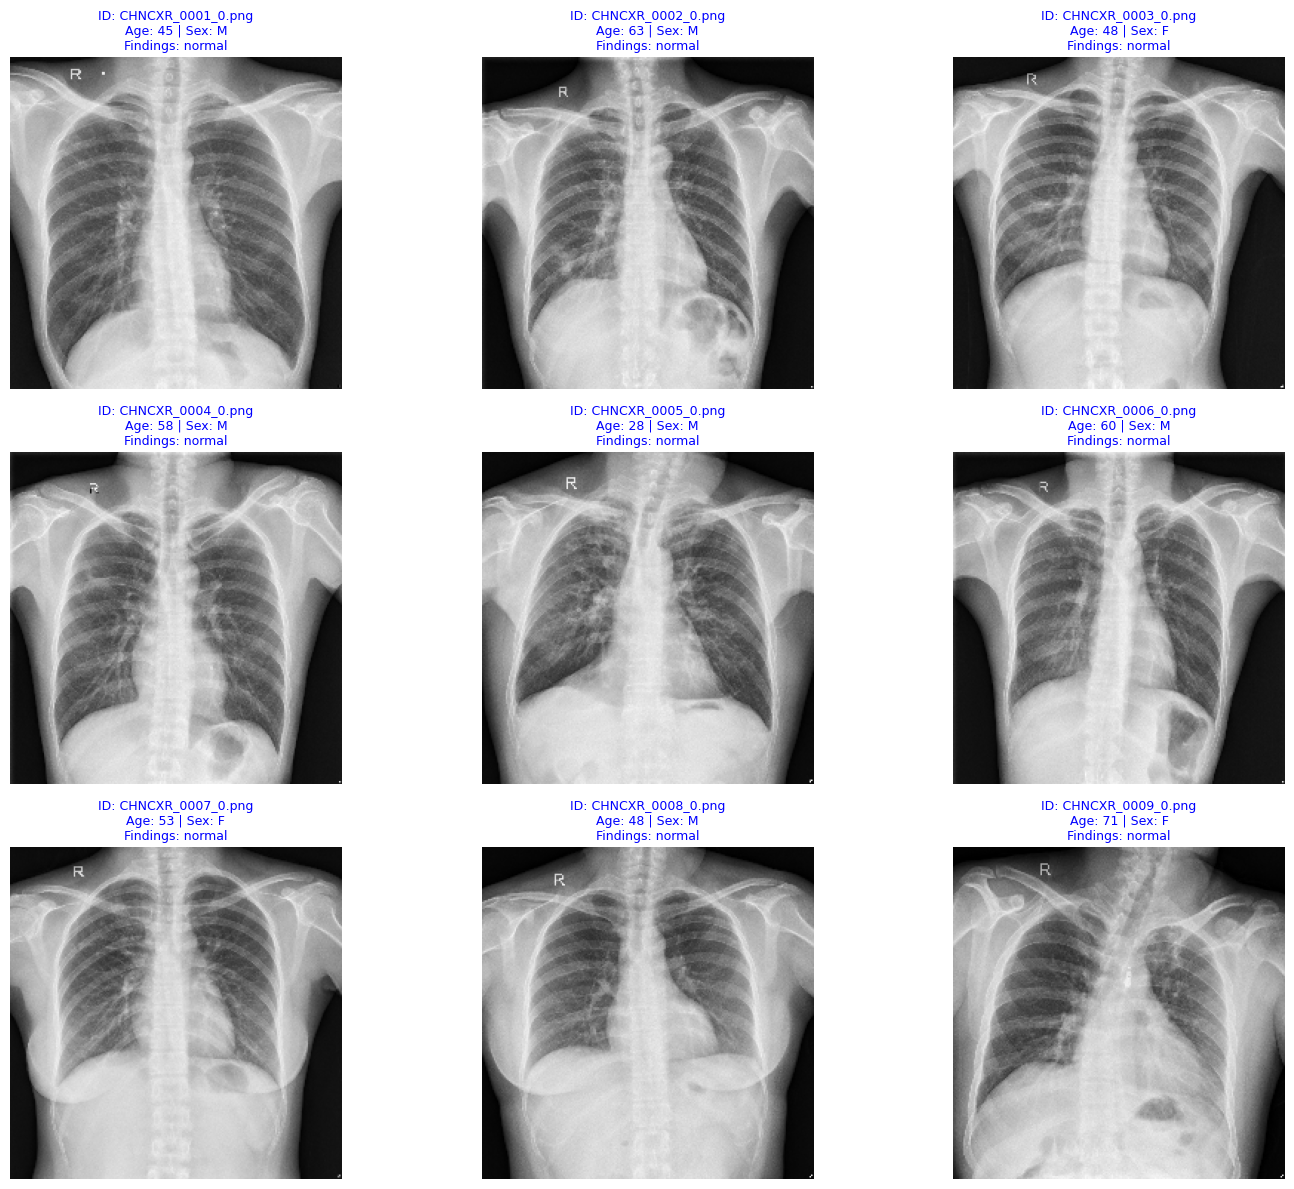

In [ ]:
# ==========================================
# CELL 5: Visualize Data
# ==========================================
import matplotlib.pyplot as plt

# 1. Grab the first batch of images
# Since label_mode=None, this only returns the image tensor
for batch_images in ds_images.take(1):
    images = batch_images.numpy() 
    # images shape: (BATCH_SIZE, 224, 224, 3)

# 2. Grab the corresponding metadata
# Because shuffle=False, the first batch corresponds to the first N rows of df
batch_size_actual = len(images)
batch_metadata = df.iloc[:batch_size_actual]

# 3. Plot a grid
plt.figure(figsize=(15, 12))
for i in range(min(batch_size_actual, 9)): # Show top 9 images
    ax = plt.subplot(3, 3, i + 1)
    
    # Display Image
    plt.imshow(images[i])
    
    # Get Info from Dataframe
    # We use .iloc to access the row by position
    row = batch_metadata.iloc[i]
    
    # Create a descriptive title
    # We truncate findings to 40 chars to keep it readable
    findings_txt = str(row['findings'])
    if len(findings_txt) > 40:
        findings_txt = findings_txt[:37] + "..."
        
    title_text = (
        f"ID: {row.get('study_id', 'N/A')}\n"
        f"Age: {row['age']} | Sex: {'M' if row['sex']==1 else 'F'}\n"
        f"Findings: {findings_txt}"
    )
    
    plt.title(title_text, fontsize=9, color='blue')
    plt.axis("off")

plt.tight_layout()
plt.show()

In [15]:
# print(X_tabular)
# print(time_event)

#### 2. Baseline Model: Cox Proportional Hazards

Before training the Deep Learning model, we establish a clinical baseline.
This helps us quantify the "added value" of the imaging modality.

In [4]:
# ==========================================
# Baseline Cox Proportional Hazards Model
# ==========================================
from lifelines import CoxPHFitter

# Fit Cox Model on Clinical Data Only
cph = CoxPHFitter()
cph_df = df[clinical_features + ["time", "event"]]
cph.fit(cph_df, duration_col="time", event_col="event")

# Evaluate
c_index_cox = cph.concordance_index_
print(f"Baseline Clinical-Only C-Index: {c_index_cox:.4f}")

# cph.print_summary() # Uncomment to see Hazard Ratios

ModuleNotFoundError: No module named 'lifelines'

#### 3. SOTA Multimodal Architecture

We implement the **Cross-Modal Attention Network** (TBSurvivalNet).

#### How it works:
1. **Image Encoder:** `DenseNet121` (without pooling) extracts a $7 \times 7$ grid of visual features.
2. **Tabular Encoder:** Clinical features are projected into a high-dimensional embedding space.
3. **Cross-Attention:** The clinical embedding acts as a "Query" to attend to the spatial visual "Keys/Values". This allows the model to focus on specific lung regions relevant to the patient's specific comorbidities.

In [ ]:
# ==========================================
# Model Initialization
# ==========================================
from tensorflow.keras.applications import DenseNet121

# 1. Define Visual Backbone
# CRITICAL CHANGE: pooling=None.
# We need the spatial (7,7,1024) features for Attention, not the global average.
image_encoder = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling=None 
)
image_encoder.trainable = False # Freeze initially

# 2. Initialize SOTA Model
# (Ensure src/model_utils.py has been updated with the CrossModalAttention class)
model = TBSurvivalNet(
    image_encoder=image_encoder,
    tabular_dim=X_tabular.shape[1],
    embed_dim=256
)

# 3. Build & Summary
# Input 1: Images (Batch, 224, 224, 3)
# Input 2: Tabular (Batch, N_features)
model.build([
    (None, 224, 224, 3), 
    (None, X_tabular.shape[1])
])

model.summary()

In [ ]:
# ==========================================
# Training Setup
# ==========================================
# Split Data (Train/Val)
# Note: In a real run, you must ensure X_img corresponds to these indices.
# Here we demonstrate the compilation.

model = compile_survival_model(
    model,
    lr=1e-4 # Lower LR is often better for fine-tuning multimodal models
)

print("Model compiled with Cox Partial Likelihood Loss.")

#### 4. Training & Explainability

Post-training, we will use **Grad-CAM** to visualize which lung regions the model focused on.

> "Clinicians require transparent, actionable models for adoption in decision-making."

In [ ]:
# generate_gradcam(
#     model,
#     image=X_img_val[0],
#     tabular_dim=X_tabular.shape[1],
#     layer_name="conv5_block16_concat"
# )

In [ ]:
# ==========================================
# Placeholder Training Loop
# ==========================================
history = model.fit(
   x=[X_img_train, X_tab_train],
   y=y_train_surv, # (time, event)
   validation_data=([X_img_val, X_tab_val], y_val_surv),
   epochs=20, # Reduced for demo
   batch_size=BATCH_SIZE
)

# Save weights for future inference
# model.save_weights("outputs/models/sota_tb_survival_v1.h5")
print("Ready for training loop execution.")

## Interpretation and Next Steps

- Compare clinical vs multimodal performance
- Perform subgroup analyses (HIV, age)
- External validation
- Competing risks modeling
- Manuscript preparation


### Summary

This notebook provides a reproducible, interpretable framework
for survival modeling in pulmonary tuberculosis using
chest X-ray imaging and clinical data.

It serves as the foundation for further validation and publication
within the **Innovative AI Healthcare Solutions** initiative.
